In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_0 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_0\all"
all_1 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_1\all"
all_2 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_2\all"

hem_0 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_0\hem"
hem_1 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_1\hem"
hem_2 = r"C:\Users\LENOVO\Desktop\LeuX\C-NMC_Leukemia\training_data\fold_2\hem"

In [3]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [4]:
img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

10661


In [5]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data) 

In [6]:
data["labels"][0:7272] = 1 # ALL
data["labels"][7272:10661] = 0 # HEM

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13228\2481703241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:7272] = 1 # ALL
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13228\2481703241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][7272:10661] = 0 # HEM


In [7]:
data["labels"] = data["labels"].astype("int64")


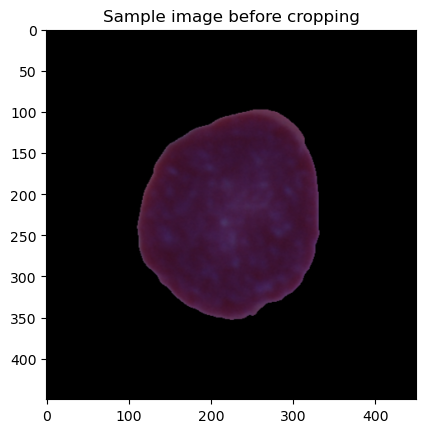

In [8]:
image = cv.imread(data["img_data"][1000])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [9]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)
print("module")


module


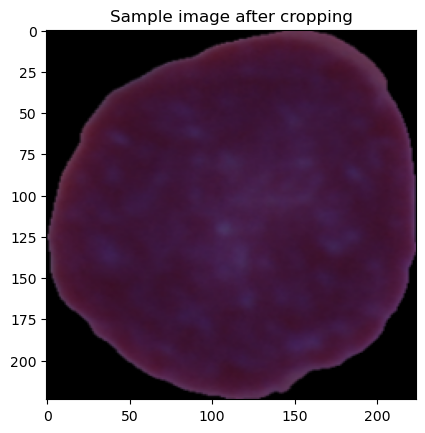

In [10]:
plt.imshow(img_list[1000])
plt.title("Sample image after cropping")
plt.show()

In [11]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [12]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    return model

In [13]:
model = feature_extract("ResNet50") # or "VGG19", "ResNet101"

In [14]:
features_list = []
for i in range(len(img_list)):
            
    image = img_list[i].reshape(-1, 224, 224, 3)
    image = preprocess_input(image)
    
    """
    # Reshaping when VGG19 model is selected
    features = model.predict(image).reshape(512,)
    """

    #Reshaping  when ResNet50 or ResNet101 model is selected
    features = model.predict(image).reshape(2048,)
    
    features_list.append(features)

1/1 [==============================] - 0s 69ms/step


In [16]:
features_df = pd.DataFrame(features_list)

In [18]:
features_df["labels"] = data["labels"]

In [20]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [21]:
x


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.253782,0.042580,0.051578,0.008029,0.057129,0.004375,0.227441,0.003590,0.005153,0.012571,...,0.561743,0.071850,0.011782,1.103319,0.290165,0.000000,0.491152,0.112431,0.000000,0.310525
1,8.079423,0.011574,0.053684,0.186905,0.000000,0.000000,0.042724,0.000000,0.574390,0.006339,...,0.209751,0.000000,0.000000,1.683905,0.019044,0.000000,0.020532,0.196671,0.081518,0.548087
2,6.266923,0.219213,0.018837,0.008474,0.000000,0.000000,0.224284,0.000000,0.000000,0.012756,...,0.137901,0.000000,0.000000,0.857915,0.159714,0.044442,0.702736,0.286233,0.070878,0.547750
3,6.486917,0.000000,0.020409,0.164188,0.000000,0.039742,0.098523,0.000000,0.136671,0.093839,...,0.383021,0.041494,0.000000,2.700690,0.249594,0.000000,0.152288,0.462612,0.330928,0.708187
4,5.148223,0.060939,0.000000,0.106593,0.000000,0.036498,0.074917,0.095883,0.034331,0.008917,...,0.175660,0.030388,0.190983,0.357074,0.000000,0.015142,0.291253,0.187770,0.045915,0.046781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,5.135459,0.023519,0.000000,0.013403,0.095962,0.044262,0.067926,0.006756,0.088878,0.000000,...,0.048080,0.036390,0.021044,0.119651,0.045240,0.000000,0.611429,0.220862,0.202260,1.137161
10657,5.458828,0.028126,0.000000,0.173168,0.000000,0.006622,0.014663,0.024785,0.046513,0.125333,...,0.638946,0.064940,0.215364,0.566119,0.000000,0.000000,0.363782,0.380672,1.268512,0.600716
10658,5.933908,0.000000,0.000000,0.069616,0.000000,0.110708,0.000000,0.000000,0.008634,0.000000,...,0.152811,0.000000,0.011421,0.638716,0.095322,0.000000,0.569343,0.919506,0.474505,0.909485
10659,5.647941,0.059169,0.000000,0.116159,0.007541,0.000000,0.112060,0.000000,0.081253,0.293994,...,1.008240,0.030306,0.088561,0.514058,0.000000,0.000000,0.012645,0.703623,0.492333,1.778768


In [22]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2048


In [23]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [25]:
x_ = pd.DataFrame(x_)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():
    
    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier())
    rfe_selector.fit(x_, y)
    
    rfe_support = rfe_selector.get_support()
    rfe_feature = x_.loc[:,rfe_support].columns.tolist()
    
    rfe_x = x_[rfe_feature]
    return rfe_x

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x, y)
    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()
    
    rf_x = x[embeded_rf_feature]
    return rf_x

In [30]:
fs_x = rf_fs() # feature selection methods "anova_fs", "RFE_fs"

In [31]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 618


In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

In [34]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

In [35]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}
 
SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [36]:
print(SVM_grid.best_params_)
 
print(SVM_grid.best_estimator_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [37]:
svm_clf = svm.SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.901


In [38]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.904
recall : 0.956
f1-score: 0.930
weighted f1-score: 0.899


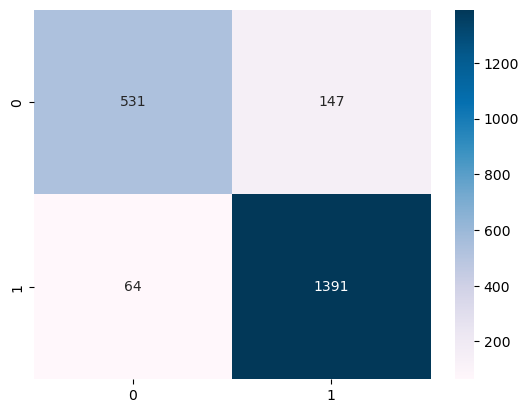

In [39]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

In [42]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = svm_score_ * 100
save_path = ''

# Save model
save_id = 'LeuX2.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = 'LeuX_weights2.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project SubjectLeuX2


C:\Users\LENOVO\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as LeuX2.h5
weights were saved as LeuX_weights2.h5


In [43]:
print(model_save_loc)

LeuX2.h5
